#Create the environment

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


In [62]:
import pandas as pd
import xarray as xr
import numpy as np
import random

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

#Load dataset and clean

In [63]:
dataset = xr.open_dataset('Data/dataset_complete_for_model_CO.nc')
dataset

<xarray.Dataset>
Dimensions:            (latitude: 33, longitude: 33, time: 744)
Coordinates:
  * time               (time) datetime64[ns] 2019-05-01 ... 2019-05-31T23:00:00
  * latitude           (latitude) float64 43.0 43.25 43.5 ... 50.5 50.75 51.0
  * longitude          (longitude) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
Data variables: (12/32)
    EMISSIONS_2019     (latitude, longitude, time) float64 ...
    u10                (latitude, longitude, time) float64 ...
    v10                (latitude, longitude, time) float64 ...
    hcc                (latitude, longitude, time) float64 ...
    lcc                (latitude, longitude, time) float64 ...
    tcc                (latitude, longitude, time) float64 ...
    ...                 ...
    CO2_tc_add_trend   (latitude, longitude, time) float64 ...
    CH4_tc_add_trend   (latitude, longitude, time) float64 ...
    NO2_tc_add_trend   (latitude, longitude, time) float64 ...
    CO_tc_add_trend    (latitude, longitude, time) float64 ...
    O3_tc_add_trend    (latitude, longitude, time) float64 ...
    traffic            (latitude, longitude, time) float64 ...

In [64]:
df = dataset.to_dataframe()
df = df.dropna()
df.head()

EMISSIONS_2019  ...  traffic
latitude longitude time                                 ...         
43.25    4.0       2019-05-01 12:00:00    6.484499e-13  ...      0.0
                   2019-05-01 13:00:00    6.373653e-13  ...      0.0
                   2019-05-01 14:00:00    6.484499e-13  ...      0.0
                   2019-05-01 15:00:00    6.318230e-13  ...      0.0
                   2019-05-01 16:00:00    6.429076e-13  ...      0.0

[5 rows x 32 columns]

In [65]:
df.shape

(393875, 32)

#Managing dataframe

Now we create the feature days and hours

In [66]:
df_flat = df
df_flat['days'] = df_flat.index.get_level_values("time").day 
df_flat['hours'] = df_flat.index.get_level_values("time").hour
df_flat = df_flat.reset_index()
df_flat = df_flat.drop(["time"], axis=1)
df_flat.head()

,latitude,longitude,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcw,tot_wind,tmp_shift_8,tot_wind_shift_12,rel_hum_shift_8,height,built,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend,traffic,days,hours
0,43.25,4.0,6.484499e-13,0.285356,2.319711,0.018088,-2.980232e-08,0.018088,0.082098,0.25119,100360.708374,265.376963,0.000004,0.000194,12.639999,2.337196,262.111437,5.530020,0.000262,0.011574,0.00027,0.000002,412.511468,1876.872673,0.000002,0.001024,0.007330,0.000001,412.361549,1874.381777,0.000003,0.001050,0.007345,0.0,1,12
1,43.25,4.0,6.373653e-13,0.203581,2.883800,0.016387,3.089180e-03,0.019478,0.082098,0.25119,100329.526937,265.477766,0.000004,0.000192,12.728169,2.890977,261.326938,5.079804,0.000282,0.011574,0.00027,0.000002,412.511543,1875.634344,0.000002,0.001032,0.007318,0.000001,412.327826,1872.541453,0.000003,0.001036,0.007455,0.0,1,13
2,43.25,4.0,6.484499e-13,0.121806,3.447889,0.014686,6.178389e-03,0.020868,0.082098,0.25119,100298.345500,265.578569,0.000004,0.000190,12.816339,3.450040,260.542440,4.694267,0.000303,0.011574,0.00027,0.000001,412.511618,1874.396014,0.000002,0.001040,0.007305,0.000001,412.306684,1872.394813,0.000003,0.001038,0.007430,0.0,1,14
3,43.25,4.0,6.318230e-13,0.040032,4.011978,0.012986,9.267598e-03,0.022259,0.082098,0.25119,100267.164062,265.679372,0.000004,0.000188,12.904509,4.012178,261.008162,4.390482,0.000293,0.011574,0.00027,0.000001,412.511694,1873.157685,0.000003,0.001048,0.007293,0.000001,412.280245,1872.238919,0.000003,0.001039,0.007406,0.0,1,15
4,43.25,4.0,6.429076e-13,0.154884,4.080582,0.013983,1.355723e-02,0.068497,0.082098,0.25119,100265.157104,265.827684,0.000004,0.000186,13.140744,4.083521,261.473884,4.175291,0.000282,0.011574,0.00027,0.000001,412.511769,1871.919356,0.000003,0.001056,0.007280,0.000001,412.248509,1872.073772,0.000003,0.001041,0.007385,0.0,1,16


Split the dataframe in features and target

In [67]:
X = df_flat.drop(columns = ['EMISSIONS_2019'])
y = df_flat['EMISSIONS_2019']

input_variables = X.columns
target_variable = 'EMISSIONS_2019'

seed = 1234

Normalizing

In [68]:
scaler = MinMaxScaler()
df_sc = scaler.fit_transform(df_flat)

df_norm = pd.DataFrame(df_sc, columns=df_flat.columns)
df_norm.head()

,latitude,longitude,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcw,tot_wind,tmp_shift_8,tot_wind_shift_12,rel_hum_shift_8,height,built,NO_tc,CO2_tc,CH4_tc,NO2_tc,CO_tc,O3_tc,NO_tc_add_trend,CO2_tc_add_trend,CH4_tc_add_trend,NO2_tc_add_trend,CO_tc_add_trend,O3_tc_add_trend,traffic,days,hours
0,0.0,0.0,0.000106,0.439646,0.727017,0.018088,4.470330e-08,0.018088,0.102538,0.256059,0.932007,0.305300,0.059347,0.489199,0.302064,0.138318,0.105822,0.327477,0.781274,0.001282,0.001063,0.326037,0.860642,0.747803,0.064463,0.796936,0.182792,0.120147,0.877719,0.819828,0.137957,0.925361,0.167591,8.775587e-09,0.0,0.521739
1,0.0,0.0,0.000104,0.435159,0.750462,0.016387,3.089242e-03,0.019478,0.102538,0.256059,0.930657,0.311457,0.054000,0.479877,0.304726,0.171126,0.057900,0.300804,0.871006,0.001282,0.001063,0.315249,0.860654,0.737382,0.069884,0.811318,0.179467,0.119682,0.871018,0.799311,0.142278,0.897497,0.200375,8.775587e-09,0.0,0.565217
2,0.0,0.0,0.000106,0.430671,0.773908,0.014686,6.178438e-03,0.020868,0.102538,0.256059,0.929308,0.317615,0.048652,0.470554,0.307388,0.204248,0.009978,0.277963,0.960737,0.001282,0.001063,0.304460,0.860665,0.726962,0.075305,0.825701,0.176142,0.118838,0.866817,0.797676,0.138482,0.900819,0.192721,8.775587e-09,0.0,0.608696
3,0.0,0.0,0.000103,0.426184,0.797353,0.012986,9.267635e-03,0.022259,0.102538,0.256059,0.927958,0.323773,0.043304,0.461231,0.310050,0.237552,0.038427,0.259965,0.916038,0.001282,0.001063,0.293671,0.860677,0.716541,0.080726,0.840084,0.172816,0.117458,0.861563,0.795939,0.135205,0.903873,0.185701,8.775587e-09,0.0,0.652174
4,0.0,0.0,0.000105,0.432486,0.800204,0.013983,1.355725e-02,0.068496,0.102538,0.256059,0.927871,0.332832,0.037526,0.455556,0.317183,0.241779,0.066876,0.247216,0.871339,0.001282,0.001063,0.282882,0.860688,0.706121,0.086147,0.854467,0.169491,0.115542,0.855257,0.794097,0.132446,0.906659,0.179315,8.775587e-09,0.0,0.695652


#Baseline performance: Linear regression with 10 fold cross validation

In [69]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[input_variables], df_norm[target_variable], cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.324 StdDev 0.009


#Reduced variance feature selection

In [70]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", X.loc[:, mask].columns)
print("      Deleted Features = ", X.loc[:, ~mask].columns)

Reduced data set shape =  (393875, 18)
     Selected features =  Index(['latitude', 'longitude', 'u10', 'v10', 'sp', 'tmp', 'tcw', 'tot_wind',
       'tmp_shift_8', 'tot_wind_shift_12', 'height', 'CO2_tc', 'CH4_tc',
       'CO2_tc_add_trend', 'CH4_tc_add_trend', 'traffic', 'days', 'hours'],
      dtype='object')
      Deleted Features =  Index(['hcc', 'lcc', 'tcc', 'cvl', 'cvh', 'sp_hum', 'rel_hum',
       'rel_hum_shift_8', 'built', 'NO_tc', 'NO2_tc', 'CO_tc', 'O3_tc',
       'NO_tc_add_trend', 'NO2_tc_add_trend', 'CO_tc_add_trend',
       'O3_tc_add_trend'],
      dtype='object')


In [71]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, X.loc[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.292 StdDev 0.009


#Principal Component Analysis

In [72]:
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(df_norm[input_variables])
full_fitted_model.explained_variance_ratio_

array([2.07502280e-01, 1.20204037e-01, 1.08974862e-01, 9.53300089e-02,
       8.55777595e-02, 6.62711939e-02, 5.54113925e-02, 5.31772152e-02,
       4.34821802e-02, 2.91206452e-02, 2.36427588e-02, 1.85183987e-02,
       1.63951593e-02, 1.37877825e-02, 9.86575684e-03, 8.83982746e-03,
       7.72431052e-03, 7.07478509e-03, 5.92036930e-03, 4.97743947e-03,
       3.88243290e-03, 3.44303693e-03, 2.64325065e-03, 2.31892070e-03,
       1.98712331e-03, 1.37482295e-03, 6.60996668e-04, 4.58489006e-04,
       3.66073462e-04, 3.29328447e-04, 2.76168900e-04, 2.00678467e-04,
       1.21591331e-04, 7.42459874e-05, 6.46774366e-05])

In [73]:
x_max=len(X.columns)
x_max

35

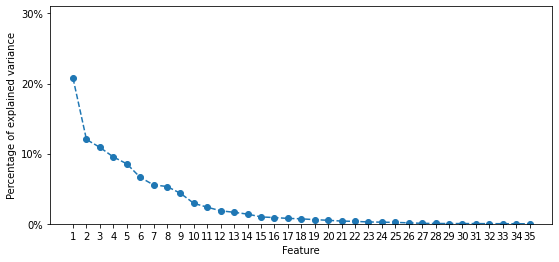

In [74]:
plt.figure(figsize=(9, 4))
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.0,0.31,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.31,.1)]);
plt.ylim([0.0,0.31]);

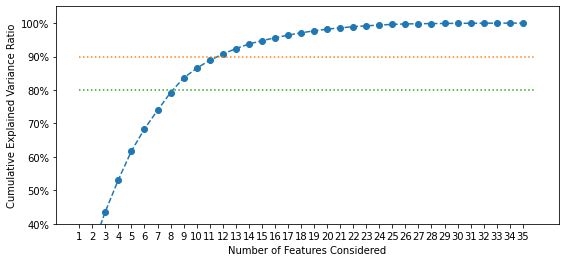

In [75]:
plt.figure(figsize=(9, 4))
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,x_max],[.9,.9],':');
plt.plot([0,x_max],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [76]:
feature_selection_pca_model = PCA(n_components=10)
fitted_model = feature_selection_pca_model.fit(df_norm[input_variables])

X_selected_features_pca = fitted_model.transform(df_norm[input_variables])
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.865
Reduced data set shape = (393875, 10)


In [77]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.146 StdDev 0.005


#Random Forest feature importance

In [78]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(df_norm[input_variables], df_norm[target_variable])
importances = forest.feature_importances_
importances

array([0.05010188, 0.06695338, 0.00900427, 0.01250921, 0.01269491,
       0.0077927 , 0.01049803, 0.04807987, 0.04340585, 0.02860372,
       0.00636838, 0.01784717, 0.0071306 , 0.01610795, 0.00968614,
       0.00992213, 0.02084114, 0.01004608, 0.1034584 , 0.10670733,
       0.01569303, 0.00723462, 0.01475038, 0.00501623, 0.02637135,
       0.01004352, 0.01316528, 0.01344265, 0.01248925, 0.02048347,
       0.03673751, 0.01314299, 0.1149442 , 0.03479628, 0.06393009])

Feature ranking:
 1. feature 32 traffic (0.115)
 2. feature 19   built (0.107)
 3. feature 18  height (0.103)
 4. feature  1 longitude (0.067)
 5. feature 34   hours (0.064)
 6. feature  0 latitude (0.050)
 7. feature  7     cvl (0.048)
 8. feature  8     cvh (0.043)
 9. feature 30 CO_tc_add_trend (0.037)
10. feature 33    days (0.035)
11. feature  9      sp (0.029)
12. feature 24   CO_tc (0.026)
13. feature 16 tot_wind_shift_12 (0.021)
14. feature 29 NO2_tc_add_trend (0.020)
15. feature 11  sp_hum (0.018)
16. feature 13     tcw (0.016)
17. feature 20   NO_tc (0.016)
18. feature 22  CH4_tc (0.015)
19. feature 27 CO2_tc_add_trend (0.013)
20. feature 26 NO_tc_add_trend (0.013)
21. feature 31 O3_tc_add_trend (0.013)
22. feature  4     hcc (0.013)
23. feature  3     v10 (0.013)
24. feature 28 CH4_tc_add_trend (0.012)
25. feature  6     tcc (0.010)
26. feature 17 rel_hum_shift_8 (0.010)
27. feature 25   O3_tc (0.010)
28. feature 15 tmp_shift_8 (0.010)
29. feature 14 tot_wind (0.010)
30. fea

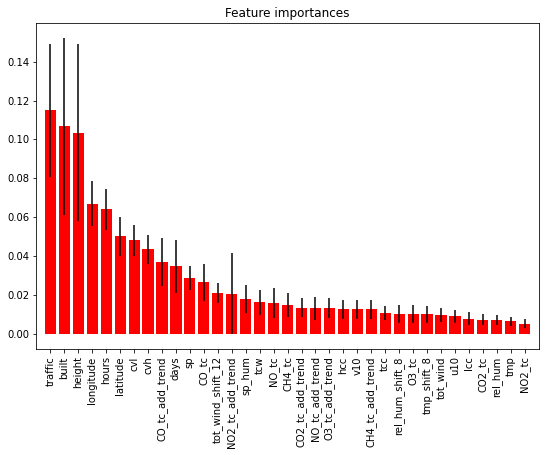

In [79]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[input_variables].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[input_variables].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(9, 6))
plt.title("Feature importances")
plt.bar(range(df_norm[input_variables].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[input_variables].shape[1]), df_norm[input_variables].columns[indices],rotation=90)
plt.xlim([-1, df_norm[input_variables].shape[1]])
plt.show()

#XGboost regressor

Split train and test

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df_norm[input_variables], df_norm[target_variable], test_size=0.20, random_state=42)

XGboost regressor

In [81]:
XGBModel = XGBRegressor()
XGBModel.fit(X_train, y_train, verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE [s] = ', MAE )

[21:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE [s] =  0.00909141854892071


[]

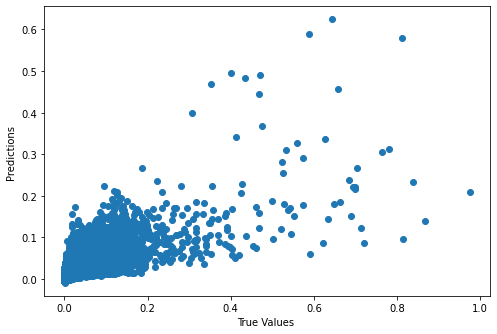

In [82]:
test_predictions = XGBpredictions

plt.figure(figsize=(8, 6))
plt.axes(aspect='equal')
plt.scatter(y_test.values.tolist(), test_predictions.tolist())
plt.xlabel('True Values ')
plt.ylabel('Predictions ')
plt.plot()

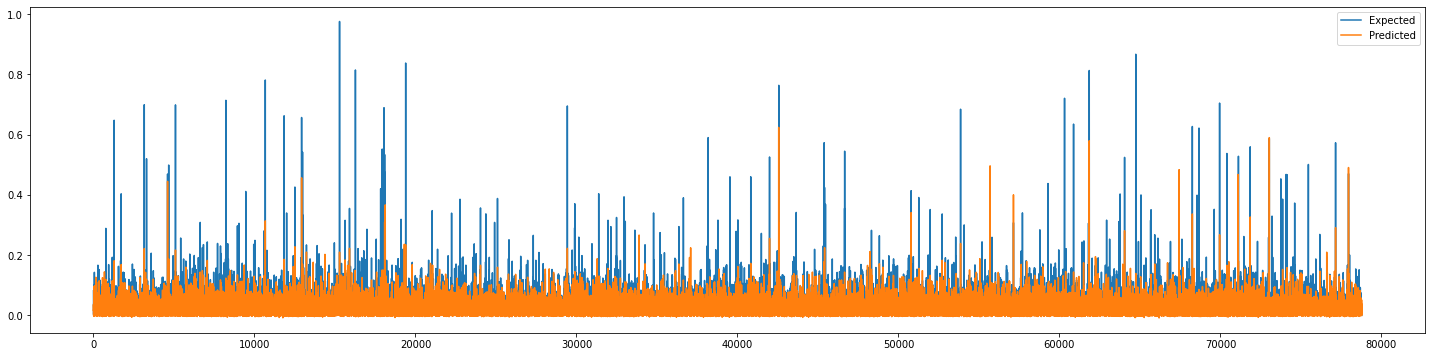

In [83]:
plt.figure(figsize=(25, 6))
plt.plot(y_test.values.tolist(), label='Expected')
plt.plot(test_predictions.tolist(), label='Predicted')
plt.legend()
plt.show()